# Анализ новостей

Это домашнее задание будет довольно большим. В нём мы попробуем кучу разных штук. Работать мы будем с датасетом новостей с РИА-новости за 2018 год. Он состоит из двух частей: 

* Новости с сайта https://ria.ru, заботливо собранные мной для вас.
* Новости из оффициальной группы РИА-новости вконтакте, а также комментарии к ним. Они тоже собирались для вас мной с заботой. 

Задание состоит из $4$ частей. Первые две являются обязательными. Последние две опциональными (зависит от вашего терпения). 

1. Нужно обучить на корпусе новостей рекурентную нейронную сетку и сгенерировать парочку новых, никогда ранее не существовавших новостей. 
2. Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова - тематики новости. Нужно научиться предсказывать ключевые слова по тексту новости. Для этого придётся собрать свою собственную архитектуру со своей собственной предобработкой. 
3. __Необязательно:__ Обучите на твиттере сентимент-классификатор. Примените его к комментариям, оставленным под соответсвующими новостями. Выявите топ позитивных новостей и топ негативных. Проанализируйте как температура комментария (вероятность того, что он негативный) зависит от длины трэда (число комментариев под новостью). Определите какие тематики новостей самые негативные, а какие самые позитивные.  
4. __Необязательно:__  Нужно обучить сентимент-классификатор на корпусе новостей из твиттера, но в качестве эмбедингов использовать ELMO слой, позаимствованный через tensor hub у лаборатории IPavlov. Можно не включать его в архитектуру, а просто прогнать через него выборку и сохранить. На вашем месте я бы усреднял каждый твитт по всем векторам и сохранял бы для каждого твитта только один вектор. 

Одним словом говоря, нас ждёт огромная работа. К счастью у вас есть тетрадки с семинаров, которые помогут вам в ней. 

__Внимание!__ сейчас мы будем насиловать опертивную память своего компьютера. Данные и модели будут гиговые, память будет быстро забиваться. Иногда тетрадка будет вылетать, а ядро умирать. Попытайтесь подгружать в неё только те данные, которые вам необходимы на данном этапе работы. Также рекомендуется сохранять промежуточные результаты, когда я рекомендую это сделать, чтобы впоcледствии не терять время попусту из-за умершего ядра. 

# 1. Знакомство с данными 

Давайте подгрузим все данные, которые у нас есть и подумаем как лучше с ними работать так, чтобы не запутаться и не сойти с ума. Все данные весят около 2 гигов. На самом деле я рекомендовал бы работать только с актуальными реально необходимыми для текущего куска задачи данными. 

In [1]:
import tensorflow as tf

In [2]:
import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
tf.__version__

'2.1.0'

In [5]:
import pickle

# Подгружаем все данные, что у нас есть 
with open('data/ria_news_2018.pickle', 'rb') as f:
    ria_news = pickle.load(f)
    
with open('data/ria_vk_posts', 'rb') as f:
    vk_news = pickle.load(f)
    
with open('data/ria_vk_comments', 'rb') as f:
    vk_comments = pickle.load(f)
    
print('Всего новостей за 2018 год:', len(ria_news))
print('Всего новостей в группе вк', len(vk_news))
print('Всего комментариев в группе вк', len(vk_comments))

Всего новостей за 2018 год: 201797
Всего новостей в группе вк 32277
Всего комментариев в группе вк 4040551


Каждая новость, пост, комментарий - это небольшой питоновский словарик. Посмотрим на примеры.

In [6]:
# Иньересующие нас поля: 
# category - рубрика с сайта
# date - дата публикации 
# keywords - ключевые слова
# shows - число просмотров новости 
# text - текст новости 
# title - заголовок новости
# href - ссылка на новость

ria_news[0]

{'category': 'В мире',
 'date': '2018-12-31',
 'day': '31',
 'href': '/20181231/1548961410.html',
 'image': 'https://cdn25.img.ria.ru/images/153303/06/1533030626_0:247:3501:2216_1036x0_80_0_0_291c92f1d31f7b2a613588e6a96164cb.jpg',
 'keywords': 'биньямин нетаньяху, израиль, в мире',
 'month': '12',
 'shows': '728',
 'snippet': 'Премьер-министр Израиля Биньямин Нетаньяху не намерен уходить в отставку в случае предъявления ему обвинений в коррупции, сообщает израильский телеканал i24... РИА Новости, 31.12.2018',
 'tags': 'Биньямин Нетаньяху, Израиль, В мире',
 'text': 'МОСКВА, 31 дек - РИА Новости. Премьер-министр Израиля Биньямин Нетаньяху не намерен уходить в отставку в случае предъявления ему обвинений в коррупции, сообщает израильский телеканал i24 News. В начале декабря полиция рекомендовала генпрокуратуре предъявить обвинения в коррупции Нетаньяху и его супруге Саре по итогам расследования дела об их отношениях с руководством крупнейшей в стране телекоммуникационной компании "Безек"

In [7]:
# Интересующие нас поля: 
# date - дата поста (число секунд прошедшее с 1 января 1970 года)
# id - идентификатор поста 
# text - содержание поста
# title - заголовок новости 
# url - ссылка на новость
# likes - число лайков 
# comments - число комментов под постом

vk_news[10]

{'likes': 144,
 'reposts': 8,
 'comments': 151,
 'text': '',
 'date': 1549047725,
 'from_id': -15755094,
 'id': 24005074,
 'owner_id': -15755094,
 'url': 'https://ria.ru/20190201/1550257362.html',
 'title': 'Лукашенко поручил убрать из школьных программ "все лишнее"'}

In [8]:
# Интересующие нас поля: 
# date - дата поста (число секунд прошедшее с 1 января 1970 года)
# id - id комментария 
# post_id - id поста, к которому был оставлен комментарий 
# likes - число лайков на комментарии 
# text - текст комментария 

vk_comments[0]

{'id': 24003685,
 'from_id': 529161030,
 'date': 1549038419,
 'text': 'встану утром рано, выпью чашку ртути и пойду подохну в этом институте',
 'likes': 39,
 'post_id': 24003681,
 'group_id': '15755094'}

Познакомились? Теперь попробуйте побороть страх пустоты. Код придётся писать чуть ли не с нуля. 

# 2. Новые новости 

Тут всё просто. Нейросетку надо обучить по аналогии с тем, что мы делали с Евгением Онегиным на паре. Прошу вас, не ставить много экспериментов с выведением текстов после каждой эпохи. Один раз обучите нейросеть и выдайте фэйковую новсть только после последней эпохи. Выбор конкретной модификации Softmax поясните. 

In [9]:
# ваш код 

In [10]:
type(ria_news), len(ria_news), type(ria_news[0]), type(ria_news[0]['text']), ria_news[0]

(list,
 201797,
 dict,
 str,
 {'category': 'В мире',
  'date': '2018-12-31',
  'day': '31',
  'href': '/20181231/1548961410.html',
  'image': 'https://cdn25.img.ria.ru/images/153303/06/1533030626_0:247:3501:2216_1036x0_80_0_0_291c92f1d31f7b2a613588e6a96164cb.jpg',
  'keywords': 'биньямин нетаньяху, израиль, в мире',
  'month': '12',
  'shows': '728',
  'snippet': 'Премьер-министр Израиля Биньямин Нетаньяху не намерен уходить в отставку в случае предъявления ему обвинений в коррупции, сообщает израильский телеканал i24... РИА Новости, 31.12.2018',
  'tags': 'Биньямин Нетаньяху, Израиль, В мире',
  'text': 'МОСКВА, 31 дек - РИА Новости. Премьер-министр Израиля Биньямин Нетаньяху не намерен уходить в отставку в случае предъявления ему обвинений в коррупции, сообщает израильский телеканал i24 News. В начале декабря полиция рекомендовала генпрокуратуре предъявить обвинения в коррупции Нетаньяху и его супруге Саре по итогам расследования дела об их отношениях с руководством крупнейшей в стра

In [11]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [12]:
import re

In [13]:
re.sub('the', 'my', 'the cat is on the mat')

'my cat is on my mat'

In [14]:
ria_news = ria_news[:1000]

In [15]:
ria_news.__len__()

1000

In [16]:
START_CHAR = '\b'
END_CHAR = '\t'
PADDING_CHAR = '\a'

chars = set([START_CHAR, '\n', END_CHAR])


for text in ria_news:
    chars.update(list(re.sub(r'[^A-Za-zА-я0-9.,;?!#\-\s]', '', text['text']).strip().lower()))
    
# заведём словари с отображением символов в числа и обратно    
char_indices = { c : i for i,c in enumerate(sorted(list(chars))) }
char_indices[PADDING_CHAR] = 0
indices_to_chars = { i : c for c,i in char_indices.items() }
num_chars = len(chars)

# num_chars # уникальные символы

In [17]:
# char_indices, indices_to_chars

In [18]:
import numpy as np

def get_one(i, sz):
    res = np.zeros(sz)
    res[i] = 1
    return res

char_vectors = {
    c : (np.zeros(num_chars) if c == PADDING_CHAR else get_one(v, num_chars))
    for c,v in char_indices.items()
}

In [19]:
from nltk.tokenize import sent_tokenize

text = []

for i in ria_news:
    text.append(re.sub(r'[^A-Za-zА-я0-9.,;?!#\-\s]', '', i['text']))

    
sentences = sent_tokenize(' '.join(text).lower())
sentences[:100]

['москва, 31 дек - риа новости.',
 'премьер-министр израиля биньямин нетаньяху не намерен уходить в отставку в случае предъявления ему обвинений в коррупции, сообщает израильский телеканал i24 news.',
 'в начале декабря полиция рекомендовала генпрокуратуре предъявить обвинения в коррупции нетаньяху и его супруге саре по итогам расследования дела об их отношениях с руководством крупнейшей в стране телекоммуникационной компании безек.',
 'как отмечает телеканал, в случае предъявления обвинений глава правительства законодательно обязан уйти в отставку только в случае, если будет исчерпан его апелляционный ресурс.',
 'нетаньяху проходит подозреваемым еще по двум другим уголовным делам, которые полиция уже передала в прокуратуру с рекомендацией предъявить ему те же обвинения  во взяточничестве, мошенничестве и злоупотреблении доверием.',
 'во всех случаях премьер настаивает на своей невиновности, выражает уверенность, что расследования против него завершатся ничем, и обещает еще многие годы

In [20]:
sentences.__len__()

10945

In [21]:
def get_matrices(sentences):
    max_sentence_len = np.max([len(x) for x in sentences])
    X = np.zeros((len(sentences), max_sentence_len, len(chars)), dtype = np.bool)
    Y = np.zeros((len(sentences), max_sentence_len, len(chars)), dtype = np.bool)
    
    for i, sentence in enumerate(sentences):
        char_seq = (START_CHAR + sentence + END_CHAR).ljust(
                      max_sentence_len + 1, PADDING_CHAR)
        for t in range(max_sentence_len):
            
            
            X[i, t, :] = char_vectors[char_seq[t]]
            Y[i, t, :] = char_vectors[char_seq[t+1]]
    return X,Y

In [22]:
get_matrices(sentences[2:5])[0].shape

(3, 233, 79)

In [23]:
import tensorflow as tf

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, TimeDistributed, Activation

model = Sequential()
model.add(LSTM(units=128, activation = 'tanh', 
               return_sequences = True, input_dim = num_chars))
model.add(Dropout(0.2))
model.add(Dense(units = num_chars))
model.add(Activation('softmax'))

In [25]:
from tensorflow.keras.optimizers import Adam
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(clipnorm = 1.), metrics = ['accuracy'])

In [26]:
# выделим тестовую выборку
test_indices = np.random.choice(range(len(sentences)), int(len(sentences) * 0.05))

sentences_train = [sentences[x] for x in set(range(len(sentences))) - set(test_indices)]
sentences_test = [sentences[x] for x in test_indices]

sentences_train = sorted(sentences_train, key = lambda x : len(x))
X_test, y_test = get_matrices(sentences_test)

batch_size = 16
def generate_batch():
    while True:
        for i in range( int(len(sentences_train)/batch_size)):
            sentences_batch = sentences_train[i*batch_size : (i+1)*batch_size]
            yield get_matrices(sentences_batch)

In [27]:
import os
from tensorflow.keras.callbacks import Callback

class CharSampler(Callback):
    def __init__(self, char_vectors, model):
        self.char_vectors = char_vectors
        self.model = model 
        
    def on_train_begin(self, logs={}):
        self.epoch = 0
        if os.path.isfile('output_file'):
            os.remove('output_file')
            
    def sample(self, preds, temperature=1.0):
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds)/temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds, 1)
        return np.argmax(probas)
    
    def sample_one(self, T):
        result = START_CHAR
        while len(result) < 500:
            Xsampled = np.zeros((1, len(result), num_chars))
            for t,c in enumerate(list(result)):
                Xsampled[0, t, :] = self.char_vectors[c]
            ysampled = self.model.predict(Xsampled, batch_size=1)[0,:]
            yv = ysampled[len(result) - 1, :]
            selected_char = indices_to_chars[self.sample(yv, T)]
            if selected_char == END_CHAR:
                break
            result = result + selected_char
        return result

    def on_epoch_end(self, batch, logs = {}):
        self.epoch_end = self.epoch + 1
        if self.epoch % 2 == 0:
            print("\nEpoch %d text sampling:" % self.epoch)
            with open('output_file', 'a') as outf:
                outf.write('\n======= Epoch %d =======\n' % self.epoch)
                for T in [0.3, 0.5, 0.7, 0.9, 1.1]:
                    print('\tsampling, T = %.1f...' % T)
                    for _ in range(5):
                        self.model.reset_states()
                        res = self.sample_one(T)
                        outf.write('\nT = %.1f\n%s\n' % (T, res[1:]))
                        

In [28]:
from tensorflow.keras.callbacks import CSVLogger
cb_logger = CSVLogger('sim/' + 'ria_news' + '.log')
cb_sampler = CharSampler(char_vectors, model)

In [29]:
model.fit_generator(generate_batch(),
                     int(len(sentences_train) / batch_size) * batch_size,
                     epochs=10,
                     verbose=True, 
                     validation_data = (X_test, y_test),
                     callbacks=[cb_logger, cb_sampler] )

Train for 10400 steps, validate on 547 samples
Epoch 1/10
10398/10400 [============================>.] - ETA: 0s - loss: 2.1063 - accuracy: 0.3692
Epoch 0 text sampling:
	sampling, T = 0.3...
	sampling, T = 0.5...
	sampling, T = 0.7...
	sampling, T = 0.9...
	sampling, T = 1.1...
10400/10400 [==============================] - 338s 33ms/step - loss: 2.1063 - accuracy: 0.3692 - val_loss: 0.5065 - val_accuracy: 0.1333
Epoch 2/10
10399/10400 [============================>.] - ETA: 0s - loss: 1.6764 - accuracy: 0.4845
Epoch 0 text sampling:
	sampling, T = 0.3...
	sampling, T = 0.5...
	sampling, T = 0.7...
	sampling, T = 0.9...
	sampling, T = 1.1...
10400/10400 [==============================] - 285s 27ms/step - loss: 1.6764 - accuracy: 0.4845 - val_loss: 0.4624 - val_accuracy: 0.1457
Epoch 3/10
10399/10400 [============================>.] - ETA: 0s - loss: 1.5665 - accuracy: 0.5152
Epoch 0 text sampling:
	sampling, T = 0.3...
	sampling, T = 0.5...
	sampling, T = 0.7...
	sampling, T = 0.9...


# 3. Новостные категории

Теперь сложнее. Можно подглядывать в семинар, который был две недели назад. Там мы классифицировали отзывы по двум классам, тут надо будет классифицировать тексты по большому их числу. Попробуйте сначала решить какие категории вы точно не собираетесь предсказывать (встречаются в данных очень редко) и избавьтесь от них. Попробуйте предсказывать для каждой новости три самых вероятных категории. Редко бывает так, что для новости верна только одна категория. Это придаст дальнейшему анализу немного плюрализма. 

In [30]:
# ваш код 

In [ ]:
# токенизировать и лемматизировать новости и загнать в эмбеддинг
# сказать, что эмбдинг - это фичи, а теги - классы классификации
# обучить LSTM, CNN и dense на кодах слов или где средний эмбеддинг по новости классифицируется
# классы сделать категориальным y
# в качестве ответа выдавать 3 наиболее вероятных predict_proba (логит)

In [213]:
import pandas as pd  # для таблиц
import numpy as np   # для матриц

# визуализация 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import re # библиотека для регулярных выражений

# лемматизатор
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

# список стоп-слов
import nltk.corpus
stopwords = set([word for word in nltk.corpus.stopwords.words('russian') if word != 'не'])

# удобный словарь
from collections import defaultdict

# слои для нейронок, которые нам пригодятся 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, Conv2D, MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [214]:
def prepare_text(text):  
    words = [morph.normal_forms(word)[0] for word in 
             re.sub('[^a-zа-я0-9]', ' ', text.lower()).split(' ') if (len(word) >= 2) and (word not in stopwords)]
    return words

In [215]:
import pickle

# Подгружаем все данные, что у нас есть 
with open('data/ria_news_2018.pickle', 'rb') as f:
    ria_news = pickle.load(f)

In [216]:
ria_news.__len__()

201797

In [217]:
ria_news = ria_news[:200000]

In [218]:
ria_news[0]

{'category': 'В мире',
 'date': '2018-12-31',
 'day': '31',
 'href': '/20181231/1548961410.html',
 'image': 'https://cdn25.img.ria.ru/images/153303/06/1533030626_0:247:3501:2216_1036x0_80_0_0_291c92f1d31f7b2a613588e6a96164cb.jpg',
 'keywords': 'биньямин нетаньяху, израиль, в мире',
 'month': '12',
 'shows': '728',
 'snippet': 'Премьер-министр Израиля Биньямин Нетаньяху не намерен уходить в отставку в случае предъявления ему обвинений в коррупции, сообщает израильский телеканал i24... РИА Новости, 31.12.2018',
 'tags': 'Биньямин Нетаньяху, Израиль, В мире',
 'text': 'МОСКВА, 31 дек - РИА Новости. Премьер-министр Израиля Биньямин Нетаньяху не намерен уходить в отставку в случае предъявления ему обвинений в коррупции, сообщает израильский телеканал i24 News. В начале декабря полиция рекомендовала генпрокуратуре предъявить обвинения в коррупции Нетаньяху и его супруге Саре по итогам расследования дела об их отношениях с руководством крупнейшей в стране телекоммуникационной компании "Безек"

In [219]:
df = pd.DataFrame( )

In [220]:
df['text'] = [news['text'] for news in ria_news]

In [221]:
df.shape

(200000, 1)

In [222]:
%%time
df['prepareNews'] = df.text.apply(prepare_text)

CPU times: user 47min 10s, sys: 343 ms, total: 47min 10s
Wall time: 47min 10s


In [223]:
df.shape

(200000, 2)

In [224]:
# df = df[df.prepareNews.apply(len) > 2]
print("Размер таблицы: ", df.shape)
df.head()

Размер таблицы:  (200000, 2)


,text,prepareNews
0,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...","[москва, 31, дек, риа, новость, премьер, минис..."
1,"ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...","[париж, 31, дек, риа, новость, результат, рефо..."
2,"МОСКВА, 31 дек - РИА Новости. Полузащитник лон...","[москва, 31, дек, риа, новость, полузащитник, ..."
3,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...","[москва, 31, дек, риа, новость, футболист, сбо..."
4,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...","[москва, 31, дек, риа, новость, аргентинский, ..."


In [225]:
# df.prepareNews[0]

In [226]:
words_count = defaultdict(lambda: 0)

for text in df.prepareNews:
    for word in text:
        words_count[word] +=1
        
len(words_count)

211208

In [227]:
top_words = 24999    # ограниичимся словарём из 25000 самых частых слов

sorted_words = sorted(words_count.items(), key=lambda w:w[1], reverse=True)
freq_words = {item[0] for item in sorted_words[:top_words]}

encoder = dict(zip(freq_words, list(range(1,len(freq_words) + 1))))

In [228]:
# функция-фильтр
def freq_filter(text):
    return np.array([encoder[word] for word in text if word in freq_words])

In [229]:
df['freq_text'] = df.prepareNews.apply(freq_filter)

In [230]:
df.head(), df.shape

(                                                text  \
 0  МОСКВА, 31 дек - РИА Новости. Премьер-министр ...   
 1  ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...   
 2  МОСКВА, 31 дек - РИА Новости. Полузащитник лон...   
 3  МОСКВА, 31 дек - РИА Новости. Футболисты сборн...   
 4  МОСКВА, 31 дек - РИА Новости. Аргентинский тен...   
 
                                          prepareNews  \
 0  [москва, 31, дек, риа, новость, премьер, минис...   
 1  [париж, 31, дек, риа, новость, результат, рефо...   
 2  [москва, 31, дек, риа, новость, полузащитник, ...   
 3  [москва, 31, дек, риа, новость, футболист, сбо...   
 4  [москва, 31, дек, риа, новость, аргентинский, ...   
 
                                            freq_text  
 0  [8474, 8927, 22219, 5604, 2537, 2095, 13031, 8...  
 1  [9793, 8927, 22219, 5604, 2537, 10782, 13286, ...  
 2  [8474, 8927, 22219, 5604, 2537, 23174, 1179, 7...  
 3  [8474, 8927, 22219, 5604, 2537, 19502, 15436, ...  
 4  [8474, 8927, 22219, 5604, 25

In [231]:
dfkeywords = [keywords['keywords'].split(',')[0] for keywords in ria_news]

In [232]:
dfkeywords

['биньямин нетаньяху',
 'эммануэль макрон',
 'фк арсенал (лондон)',
 'сердар азмун',
 'теннис',
 'кевин спейси',
 'нхл',
 'таиланд',
 'дмитрий медведев',
 'новый год',
 'индонезия',
 'амстердам',
 'сирия',
 'регулярный чемпионат нхл',
 'амстердам',
 'общество',
 'сборная южной кореи по футболу',
 'взрыв газа в жилом доме в магнитогорске',
 'алексис ципрас',
 'андреас сеппи',
 'взрыв газа в жилом доме в магнитогорске',
 'россия',
 'фк вест хэм юнайтед',
 'происшествия',
 'взрыв газа в жилом доме в магнитогорске',
 'украина',
 'происшествия',
 'р-спорт',
 'шахматы',
 'взрыв газа в жилом доме в магнитогорске',
 'мид рф',
 'происшествия',
 'взрыв газа в жилом доме в магнитогорске',
 'взрыв газа в жилом доме в магнитогорске',
 'происшествия',
 'унаи эмери',
 'взрыв газа в жилом доме в магнитогорске',
 'ситуация вокруг упц',
 'флойд мэйуэзер-младший',
 'алеппо',
 'риа наука',
 'видео',
 'польша',
 'челябинск',
 'шахматы',
 'взрыв газа в жилом доме в магнитогорске',
 'цик украины',
 'взрыв га

In [233]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [234]:
df['keywords'] = dfkeywords 

In [235]:
df['target'] = le.fit_transform(dfkeywords)

In [236]:
# list(le.classes_)

In [237]:
df.head()

,text,prepareNews,freq_text,keywords,target
0,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...","[москва, 31, дек, риа, новость, премьер, минис...","[8474, 8927, 22219, 5604, 2537, 2095, 13031, 8...",биньямин нетаньяху,1826
1,"ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...","[париж, 31, дек, риа, новость, результат, рефо...","[9793, 8927, 22219, 5604, 2537, 10782, 13286, ...",эммануэль макрон,9749
2,"МОСКВА, 31 дек - РИА Новости. Полузащитник лон...","[москва, 31, дек, риа, новость, полузащитник, ...","[8474, 8927, 22219, 5604, 2537, 23174, 1179, 7...",фк арсенал (лондон),9070
3,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...","[москва, 31, дек, риа, новость, футболист, сбо...","[8474, 8927, 22219, 5604, 2537, 19502, 15436, ...",сердар азмун,8073
4,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...","[москва, 31, дек, риа, новость, аргентинский, ...","[8474, 8927, 22219, 5604, 2537, 23319, 17192, ...",теннис,8598


In [238]:
print(pd.__version__)

1.0.3


In [259]:
list(le.classes_).__len__()

10008

In [261]:
dfkeywords = [keywords['keywords'].split(',') for keywords in ria_news]

In [262]:
df['keywords'] = dfkeywords 

In [285]:
df['prepareNews'].values.shape
# df['keywords'].values[0]

(200000,)

In [340]:
newdf = pd.DataFrame(columns=['prepareNews', 'keyword'])

In [ ]:
acum_j = 0

for i in range(df['prepareNews'].values.shape[0]):
#     if i == 10000: 
#         break
    for j in range(df['keywords'].values[i].__len__()):
        acum_j += j
        newdf.loc[i+acum_j] = [df['prepareNews'].values[i]] + [df['keywords'].values[i][j]]

In [322]:
newdf['freq_text'] = newdf.prepareNews.apply(freq_filter)

In [324]:
newdf['target'] = le.fit_transform(newdf['keyword'])

In [325]:
newdf.head(20)

,prepareNews,keyword,freq_text,target
0,"[москва, 31, дек, риа, новость, премьер, минис...",биньямин нетаньяху,"[8474, 8927, 22219, 5604, 2537, 2095, 13031, 8...",2471
1,"[москва, 31, дек, риа, новость, премьер, минис...",израиль,"[8474, 8927, 22219, 5604, 2537, 2095, 13031, 8...",809
3,"[москва, 31, дек, риа, новость, премьер, минис...",в мире,"[8474, 8927, 22219, 5604, 2537, 2095, 13031, 8...",363
4,"[париж, 31, дек, риа, новость, результат, рефо...",эммануэль макрон,"[9793, 8927, 22219, 5604, 2537, 10782, 13286, ...",4285
5,"[париж, 31, дек, риа, новость, результат, рефо...",франция,"[9793, 8927, 22219, 5604, 2537, 10782, 13286, ...",1963
7,"[париж, 31, дек, риа, новость, результат, рефо...",в мире,"[9793, 8927, 22219, 5604, 2537, 10782, 13286, ...",363
8,"[москва, 31, дек, риа, новость, полузащитник, ...",фк арсенал (лондон),"[8474, 8927, 22219, 5604, 2537, 23174, 1179, 7...",4071
9,"[москва, 31, дек, риа, новость, футболист, сбо...",сердар азмун,"[8474, 8927, 22219, 5604, 2537, 19502, 15436, ...",3837
10,"[москва, 31, дек, риа, новость, футболист, сбо...",сборная ирана по футболу,"[8474, 8927, 22219, 5604, 2537, 19502, 15436, ...",1591
11,"[москва, 31, дек, риа, новость, аргентинский, ...",теннис,"[8474, 8927, 22219, 5604, 2537, 23319, 17192, ...",3959


In [327]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(newdf.freq_text.values, newdf.target.values, test_size=0.3)

In [328]:
max_length = 100         # обрежем все посты до 20 слов

X_train = sequence.pad_sequences(X_train, maxlen=max_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_length)

In [329]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [330]:
embedding_vector_length = 64    # размерность эмбендинга
top = top_words + 1             # на вход идут слова и нулевой элемент

In [331]:
model = Sequential()
model.add(Embedding(top, embedding_vector_length, input_length=max_length))
# model.add(Conv2D(filters=1, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(list(le.classes_).__len__(), activation='softmax'))

# собираем сетку и выбираем оптимизатор для обучения
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [332]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 100, 64)           1600000   
_________________________________________________________________
lstm_19 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 4334)              559086    
Total params: 2,257,902
Trainable params: 2,257,902
Non-trainable params: 0
_________________________________________________________________


In [333]:
X_train.shape

(20191, 100)

In [334]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [335]:
es = EarlyStopping(monitor='val_accuracy', patience=10)

In [336]:
steplr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [337]:
%%time 
# гоняем сетку три эпохи
hist = model.fit(X_train, y_train, callbacks=[es, steplr], validation_split=0.15, epochs=50, batch_size=64)

Train on 17162 samples, validate on 3029 samples
Epoch 1/50
17162/17162 [==============================] - 7s 379us/sample - loss: 6.6560 - accuracy: 0.0752 - val_loss: 6.4580 - val_accuracy: 0.0789
Epoch 2/50
17162/17162 [==============================] - 5s 313us/sample - loss: 6.2927 - accuracy: 0.0776 - val_loss: 6.5138 - val_accuracy: 0.0789
Epoch 3/50
17162/17162 [==============================] - 5s 318us/sample - loss: 6.1720 - accuracy: 0.0798 - val_loss: 6.5165 - val_accuracy: 0.0918
Epoch 4/50
17162/17162 [==============================] - 5s 318us/sample - loss: 6.0010 - accuracy: 0.0894 - val_loss: 6.4530 - val_accuracy: 0.0905
Epoch 5/50
17162/17162 [==============================] - 5s 317us/sample - loss: 5.8619 - accuracy: 0.0989 - val_loss: 6.4174 - val_accuracy: 0.1076
Epoch 6/50
17162/17162 [==============================] - 5s 317us/sample - loss: 5.6893 - accuracy: 0.1198 - val_loss: 6.3486 - val_accuracy: 0.1189
Epoch 7/50
17162/17162 [===========================

In [338]:
# # качество на тесте
# scores = model.evaluate(X_test, y_test, verbose=0)
# print('Accuracy: %.4f'%(scores[1]))

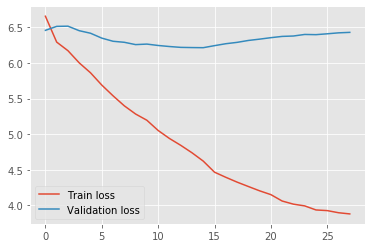

In [339]:
# когда начали переобучаться
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

# Опциональная часть с температурой комментариев

Тут нужно будет понять какие новости публиковались в социальной сетке, а какие нет. Туда идёт не полный поток новостей, а только самое важное. После можно смотреть на категории и делать сентимент-анализ комментариев. 

In [ ]:
# ваш код 